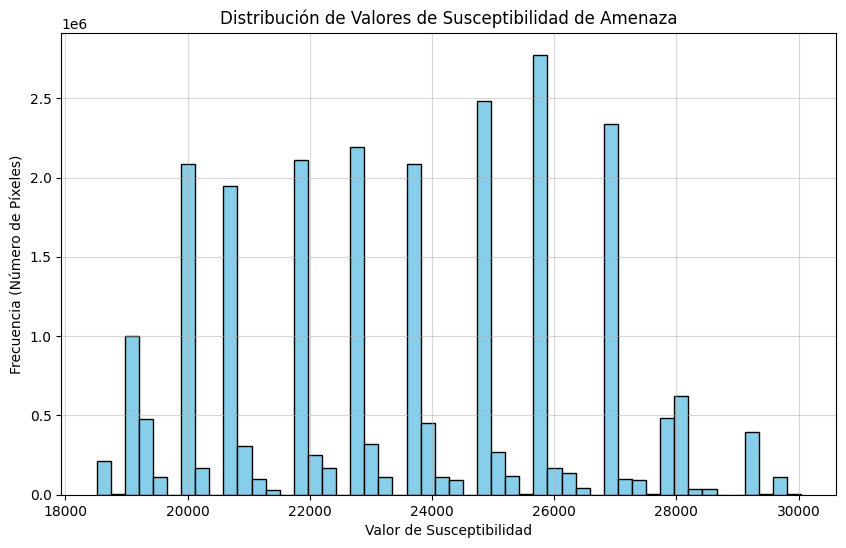

In [2]:
import numpy as np
import rasterio
import matplotlib.pyplot as plt

# Ruta a tu raster original (el que tiene los valores continuos)
ruta_in = "../data/01_raw/amenaza_arauca/arc/w001001.adf"

with rasterio.open(ruta_in) as src:
    data = src.read(1)
    NoData_value = src.nodata  # Obtenemos el valor NoData del archivo

# Filtramos los valores "Sin Datos" para el análisis
valores_reales = data[data != NoData_value]

# Creamos un histograma
plt.figure(figsize=(10, 6))
plt.hist(valores_reales, bins=50, color='skyblue', edgecolor='black')
plt.title('Distribución de Valores de Susceptibilidad de Amenaza')
plt.xlabel('Valor de Susceptibilidad')
plt.ylabel('Frecuencia (Número de Píxeles)')
plt.grid(True, alpha=0.5)
plt.show()



In [3]:
# Calculamos los umbrales usando cuantiles
umbral_bajo = np.quantile(valores_reales, 0.33)
umbral_alto = np.quantile(valores_reales, 0.66)

print(f"✅ Umbral para Amenaza BAJA: Valores <= {umbral_bajo:.2f}")
print(f"✅ Umbral para Amenaza MEDIA: Valores > {umbral_bajo:.2f} y <= {umbral_alto:.2f}")
print(f"✅ Umbral para Amenaza ALTA:  Valores > {umbral_alto:.2f}")

✅ Umbral para Amenaza BAJA: Valores <= 21798.00
✅ Umbral para Amenaza MEDIA: Valores > 21798.00 y <= 24888.00
✅ Umbral para Amenaza ALTA:  Valores > 24888.00


In [5]:
# Crear un nuevo array vacío con el mismo tamaño que el original
classified_data = np.zeros(data.shape, dtype=np.uint8)

# Aplicar las reglas de clasificación
classified_data[(data > NoData_value) & (data <= umbral_bajo)] = 1 # Baja
classified_data[(data > umbral_bajo) & (data <= umbral_alto)] = 2 # Media
classified_data[data > umbral_alto] = 3 # Alta

# Guardar este nuevo raster clasificado como un GeoTIFF
ruta_out_clasificado = "../data/02_processed/amenaza_arauca_clasificado.tif"

with rasterio.open(ruta_in) as src:
    profile = src.profile
    
    # 🔥 Cambio CLAVE: Forzamos el driver de salida a GeoTIFF
    profile['driver'] = 'GTiff'
    
    # Actualizamos el tipo de dato para nuestro nuevo raster
    profile.update(dtype=rasterio.uint8, count=1, nodata=0) 

    # Ahora sí, guardamos el archivo
    with rasterio.open(ruta_out_clasificado, 'w', **profile) as dst:
        dst.write(classified_data, 1)

print(f"\n✅ Raster reclasificado y guardado en: {ruta_out_clasificado}")


✅ Raster reclasificado y guardado en: ../data/02_processed/amenaza_arauca_clasificado.tif


In [10]:
import rasterio
import numpy as np
import folium
from rasterio.warp import calculate_default_transform, reproject, Resampling

# --- FASE A: REPROYECCIÓN DEL RASTER CLASIFICADO ---

# Ruta de entrada (nuestro raster con valores 1, 2, 3 pero en el CRS incorrecto)
ruta_in_clasificado = "../data/02_processed/amenaza_arauca_clasificado.tif"
# Ruta de salida (¡el archivo final que usaremos para el mapa!)
ruta_out_wgs84 = "../data/02_processed/amenaza_arauca_clasificado_wgs84.tif"

# Sistema de coordenadas de destino (el que usa Folium)
dst_crs = "EPSG:4326"

with rasterio.open(ruta_in_clasificado) as src:
    # Calcular la transformación necesaria para reproyectar
    transform, width, height = calculate_default_transform(
        src.crs, dst_crs, src.width, src.height, *src.bounds
    )
    
    # Copiar los metadatos y actualizarlos para el nuevo archivo
    kwargs = src.meta.copy()
    kwargs.update({
        'driver': 'GTiff',
        'crs': dst_crs,
        'transform': transform,
        'width': width,
        'height': height
    })

    # Escribir el nuevo raster reproyectado
    with rasterio.open(ruta_out_wgs84, 'w', **kwargs) as dst:
        reproject(
            source=rasterio.band(src, 1),
            destination=rasterio.band(dst, 1),
            src_transform=src.transform,
            src_crs=src.crs,
            dst_transform=transform,
            dst_crs=dst_crs,
            resampling=Resampling.nearest
        )

print(f"✅ Raster reproyectado a WGS84 y guardado en: {ruta_out_wgs84}")


# --- FASE B: VISUALIZACIÓN (AHORA SÍ FUNCIONARÁ) ---

# 🔥 ¡IMPORTANTE! Apuntar al nuevo archivo reproyectado
ruta_tif_para_mapa = ruta_out_wgs84

color_map_rgba = {
    1: (34, 139, 34, 150),   # BAJA -> Verde
    2: (255, 255, 0, 150),   # MEDIA -> Amarillo
    3: (255, 0, 0, 150),     # ALTA -> Rojo
}

with rasterio.open(ruta_tif_para_mapa) as src:
    bounds = src.bounds
    data_final = src.read(1)
    height, width = data_final.shape
    centro = [(bounds.top + bounds.bottom) / 2, (bounds.left + bounds.right) / 2]
    
    # Crear la imagen coloreada
    colored_data = np.zeros((height, width, 4), dtype=np.uint8)
    for val, color in color_map_rgba.items():
        colored_data[data_final == val] = color

# Crear el mapa Folium
m = folium.Map(location=centro, zoom_start=9)

folium.raster_layers.ImageOverlay(
    image=colored_data,
    bounds=[[bounds.bottom, bounds.left], [bounds.top, bounds.right]],
    name="Capa de Amenaza Clasificada"
).add_to(m)

folium.LayerControl().add_to(m)
m.save("mapa_amenaza_final.html")

print("✅ Mapa final coloreado y georreferenciado correctamente guardado en 'mapa_amenaza_final.html'")

m 

✅ Raster reproyectado a WGS84 y guardado en: ../data/02_processed/amenaza_arauca_clasificado_wgs84.tif
✅ Mapa final coloreado y georreferenciado correctamente guardado en 'mapa_amenaza_final.html'


In [11]:
import pandas as pd
import geopandas as gpd
import rasterio
from shapely.geometry import Point

# 1. Cargar los datos de las torres (necesitarás crear este archivo CSV)
# Asegúrate de tener un archivo CSV en: data/03_external/ubicacion_torres.csv
# Con las columnas: ID_Torre, Latitud, Longitud
try:
    torres_df = pd.read_csv("../data/03_external/ubicacion_torres.csv")
    print("✅ Archivo de torres cargado con éxito.")
except FileNotFoundError:
    print("⚠️ Archivo no encontrado. Creando un DataFrame de ejemplo.")
    # DataFrame de ejemplo si no tienes el archivo real todavía
    torres_df = pd.DataFrame({
        'ID_Torre': ['T-101', 'T-102', 'T-103', 'T-104'],
        'Latitud': [7.08, 7.10, 7.12, 7.05],
        'Longitud': [-72.25, -72.28, -72.30, -72.20]
    })

# 2. Extraer los valores del raster para cada coordenada de torre
coords = [(x, y) for x, y in zip(torres_df.Longitud, torres_df.Latitud)]

# Apuntamos a nuestro raster clasificado y reproyectado
ruta_raster_final = "../data/02_processed/amenaza_arauca_clasificado_wgs84.tif"

with rasterio.open(ruta_raster_final) as src:
    # 'sample' es un generador, lo convertimos a una lista
    valores_raster = [val[0] for val in src.sample(coords)]

# 3. Añadir los resultados al DataFrame
torres_df['Amenaza_Valor'] = valores_raster

# Mapear los valores numéricos a etiquetas legibles
mapa_amenaza_labels = {1: 'Baja', 2: 'Media', 3: 'Alta', 0: 'Sin Datos'}
torres_df['Amenaza_Nivel'] = torres_df['Amenaza_Valor'].map(mapa_amenaza_labels)

# 4. Mostrar el resultado final
print("\nResultado del cruce de información:")
print(torres_df)

# Guardar el resultado para uso futuro
ruta_salida_final = "../data/02_processed/torres_con_amenaza.csv"
torres_df.to_csv(ruta_salida_final, index=False)
print(f"\n✅ Datos de torres con nivel de amenaza guardados en: {ruta_salida_final}")

✅ Archivo de torres cargado con éxito.

Resultado del cruce de información:
    ID_Torre   Nombre   Latitud   Longitud  Amenaza_Valor Amenaza_Nivel
0  TORRE_001  Torre 1  6.642631 -71.814700              2         Media
1  TORRE_002  Torre 2  6.858107 -71.902591              1          Baja
2  TORRE_003  Torre 3  6.841745 -71.391727              1          Baja
3  TORRE_004  Torre 4  6.356094 -70.825931              3          Alta
4  TORRE_005  Torre 5  6.710830 -70.666629              1          Baja
5  TORRE_006  Torre 6  6.634446 -71.314822              2         Media
6  TORRE_007  Torre 7  6.214130 -71.946536              3          Alta

✅ Datos de torres con nivel de amenaza guardados en: ../data/02_processed/torres_con_amenaza.csv


In [12]:
import requests
import pandas as pd
import plotly.graph_objects as go

# --- CONFIGURACIÓN DE LA SIMULACIÓN ---
# Usaremos la Torre 004 que identificamos como de ALTA amenaza
torre_id = 'TORRE_004'
latitud = 6.356094
longitud = -70.825931
nivel_amenaza_estatica = 'Alta' 

# --- PASO 1: OBTENER DATOS HISTÓRICOS DE LLUVIA ---
print("🛰️ Obteniendo datos de lluvia para el último año...")
url = (
    "https://archive-api.open-meteo.com/v1/archive?"
    f"latitude={latitud}&longitude={longitud}"
    "&start_date=2024-10-01&end_date=2025-10-10" # Un año atrás desde hoy
    "&hourly=precipitation"
)
response = requests.get(url)
data = response.json()

# Convertir a un DataFrame de Pandas
df_lluvia = pd.DataFrame(data['hourly'])
df_lluvia['time'] = pd.to_datetime(df_lluvia['time'])
print("✅ Datos de lluvia obtenidos.")

# --- PASO 2: CALCULAR LLUVIA ACUMULADA ---
# Usamos una ventana rodante de 72 horas para simular el acumulado
df_lluvia['precip_acum_72h'] = df_lluvia['precipitation'].rolling(window=72, min_periods=1).sum()

# --- PASO 3: APLICAR LA LÓGICA DE LA MATRIZ DE RIESGO ---
def calcular_alerta(lluvia_acum, amenaza_estatica):
    if amenaza_estatica == 'Alta':
        if lluvia_acum > 100:
            return 'ROJA'
        elif lluvia_acum > 60:
            return 'AMARILLA'
    elif amenaza_estatica == 'Media':
        if lluvia_acum > 120:
            return 'AMARILLA'
    return 'VERDE'

df_lluvia['nivel_alerta'] = df_lluvia['precip_acum_72h'].apply(
    calcular_alerta, 
    amenaza_estatica=nivel_amenaza_estatica
)
print("✅ Lógica de alertas aplicada.")

# --- PASO 4: VISUALIZAR LA SIMULACIÓN 📊 ---
print("📊 Generando gráfico de simulación...")
fig = go.Figure()

# Añadir línea de lluvia acumulada
fig.add_trace(go.Scatter(
    x=df_lluvia['time'], 
    y=df_lluvia['precip_acum_72h'], 
    mode='lines',
    name='Lluvia Acumulada 72h (mm)',
    line=dict(color='blue')
))

# Añadir umbrales visuales
fig.add_hline(y=100, line_dash="dot", line_color="red", annotation_text="Umbral Alerta ROJA (100mm)")
fig.add_hline(y=60, line_dash="dot", line_color="orange", annotation_text="Umbral Alerta AMARILLA (60mm)")

# Resaltar los momentos en que hubo alertas
alertas_rojas = df_lluvia[df_lluvia['nivel_alerta'] == 'ROJA']
alertas_amarillas = df_lluvia[df_lluvia['nivel_alerta'] == 'AMARILLA']

fig.add_trace(go.Scatter(
    x=alertas_rojas['time'], y=alertas_rojas['precip_acum_72h'],
    mode='markers', name='Alerta ROJA Generada',
    marker=dict(color='red', size=8, symbol='x')
))
fig.add_trace(go.Scatter(
    x=alertas_amarillas['time'], y=alertas_amarillas['precip_acum_72h'],
    mode='markers', name='Alerta AMARILLA Generada',
    marker=dict(color='orange', size=6)
))

fig.update_layout(
    title=f'Simulación de Alertas Históricas para {torre_id} (Amenaza {nivel_amenaza_estatica})',
    xaxis_title='Fecha',
    yaxis_title='Precipitación Acumulada en 72h (mm)',
    legend_title='Leyenda'
)

fig.show()

🛰️ Obteniendo datos de lluvia para el último año...
✅ Datos de lluvia obtenidos.
✅ Lógica de alertas aplicada.
📊 Generando gráfico de simulación...
